In [18]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
import scipy
import os
from sklearn.model_selection import train_test_split
# turn off pink boxes for demo
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire


Using the titanic data, in your classification-exercises repository, create a notebook, model.ipynb where you will do the following:  More people died than survived.

What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy. 

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

Evaluate your in-sample results using the model score, confusion matrix, and classification report.

Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

Run through steps 2-4 using a different max_depth value.

Which model performs better on your in-sample data?

Which model performs best on your out-of-sample data, the validate set?

In [19]:
df = acquire.get_titanic_data()

In [20]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town','embarked']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [21]:
df = prep_titanic(df)

In [5]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [22]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.survived)
    return train, validate, test


train, validate, test = split_data(df)

In [23]:
train, validate, test = split_data(df)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 450 to 749
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            398 non-null    int64  
 1   pclass              398 non-null    int64  
 2   age                 398 non-null    float64
 3   sibsp               398 non-null    int64  
 4   parch               398 non-null    int64  
 5   fare                398 non-null    float64
 6   alone               398 non-null    int64  
 7   is_female           398 non-null    uint8  
 8   embark_Cherbourg    398 non-null    uint8  
 9   embark_Queenstown   398 non-null    uint8  
 10  embark_Southampton  398 non-null    uint8  
dtypes: float64(2), int64(5), uint8(4)
memory usage: 26.4 KB


In [24]:
# convert column names to lowercase, replace '.' in column names with '_'
df.columns = [col.lower().replace('.', '_') for col in df]
df

,survived,pclass,age,sibsp,parch,fare,alone,is_female,embark_cherbourg,embark_queenstown,embark_southampton
0,0,3,22.0,1,0,7.2500,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,1,0,0
2,1,3,26.0,0,0,7.9250,1,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,39.0,0,5,29.1250,0,1,0,1,0
886,0,2,27.0,0,0,13.0000,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,1,1,0,0,1
889,1,1,26.0,0,0,30.0000,1,0,1,0,0


In [25]:
# split into train, validate, test
train, validate, test = split_data(df)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived


In [26]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)


What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy. 


In [44]:
baseline_prediction = y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]
# baseline_prediction = [0.6      , 0.4      ]

array([[0.9010989, 0.0989011],
       [0.9010989, 0.0989011],
       [0.9010989, 0.0989011],
       [0.6      , 0.4      ],
       [0.9010989, 0.0989011]])

In [28]:
baseline_accuracy = (train.survived == 0).mean()
baseline_accuracy

0.5954773869346733

In [29]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)


[Text(362.7, 332.955, 'is_female <= 0.5\ngini = 0.482\nsamples = 398\nvalue = [237, 161]\nclass = 0'),
 Text(181.35, 237.825, 'age <= 6.5\ngini = 0.316\nsamples = 249\nvalue = [200, 49]\nclass = 0'),
 Text(90.675, 142.695, 'sibsp <= 3.0\ngini = 0.375\nsamples = 12\nvalue = [3, 9]\nclass = 1'),
 Text(45.3375, 47.565, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = 1'),
 Text(136.0125, 47.565, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = 0'),
 Text(272.025, 142.695, 'pclass <= 1.5\ngini = 0.281\nsamples = 237\nvalue = [197, 40]\nclass = 0'),
 Text(226.6875, 47.565, 'gini = 0.48\nsamples = 55\nvalue = [33, 22]\nclass = 0'),
 Text(317.3625, 47.565, 'gini = 0.178\nsamples = 182\nvalue = [164, 18]\nclass = 0'),
 Text(544.05, 237.825, 'pclass <= 2.5\ngini = 0.373\nsamples = 149\nvalue = [37, 112]\nclass = 1'),
 Text(453.375, 142.695, 'age <= 2.5\ngini = 0.122\nsamples = 92\nvalue = [6, 86]\nclass = 1'),
 Text(408.03749999999997, 47.565, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass =

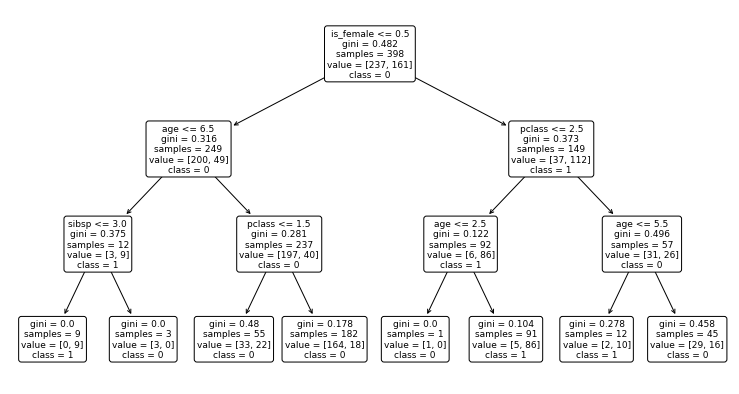

In [30]:

plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_.astype(str), rounded=True)

Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [31]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))


Accuracy of Decision Tree classifier on training set: 0.84


Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [33]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       237
           1       0.94      0.65      0.77       161

    accuracy                           0.84       398
   macro avg       0.87      0.81      0.82       398
weighted avg       0.86      0.84      0.83       398



In [34]:
# confusion matrix

confusion_matrix(y_train, y_pred)


array([[230,   7],
       [ 56, 105]])

In [35]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [36]:
pd.crosstab(y_train, y_pred)

col_0,0,1
survived,,
0,230,7
1,56,105


In [37]:
import pandas as pd

labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,230,7
1,56,105


In [38]:
y_pred = clf.predict(X_train)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       237
           1       0.94      0.65      0.77       161

    accuracy                           0.84       398
   macro avg       0.87      0.81      0.82       398
weighted avg       0.86      0.84      0.83       398



In [39]:
survibal_pred_prob = pd.DataFrame(clf.predict_proba(X_train))
survibal_pred_prob

,0,1
0,0.901099,0.098901
1,0.901099,0.098901
2,0.901099,0.098901
3,0.600000,0.400000
4,0.901099,0.098901
...,...,...
393,0.054945,0.945055
394,0.901099,0.098901
395,0.054945,0.945055
396,0.901099,0.098901


Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.


accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

In [40]:
# confusion matrix
# true positive rate, false positive rate, true negative rate, false negative rate
confusion_matrix(y_train, y_pred)


array([[230,   7],
       [ 56, 105]])

In [41]:
y_train.value_counts()

0    237
1    161
Name: survived, dtype: int64

In [42]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
# confusion matrix

confusion_matrix(y_train, y_pred)


Accuracy of Decision Tree classifier on training set: 0.84


array([[230,   7],
       [ 56, 105]])

In [43]:
import pandas as pd

labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


,0,1
0,230,7
1,56,105


Run through steps 2-4 using a different max_depth value.

Which model performs better on your in-sample data?
the second one worls 
F1 score improved by %5, tp -14, tn +14, fp -34 fn +34 

Which model performs best on your out-of-sample data, the validate set?

The second model runs better for accuracy. 

In [52]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)


In [53]:
clf.score(X_validate, y_validate)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
clf = DecisionTreeClassifier(max_depth=8, random_state=123)


In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_validate, y_validate)))
